In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
#from sewar import full_ref
from skimage import metrics, transform
#from PIL import Image
from skimage.metrics import structural_similarity as ssim
import pprint

In [2]:
img_blurry = cv.imread('images/blurry.jpg',0)
img_dark = cv.imread('images/dark.jpg',0)
img_clear = cv.imread('images/clear.jpg',0)

In [3]:
print(img_blurry.shape)

(4032, 3024)


In [4]:
def plot_images(images: list, titles: list, columns: int, font_size: int, allow_axes: bool) -> np.ndarray:

    """
    generates a plot of images for comparison, dynamic calculation of arrangement

    Parameters: 
        images (list): list of variables referencing an image
        titles (list): list of strings describing the image
        columns: (integer): number of columns for plot
        font_size (integer): fontsize of subplot titles
        allow_axes (boolean): if true, adds axes by default. else, removes axes

    Returns:
        matrix of pixel values for each image (np.array)
        a plot (image)
    """
    images_len = len(images)
    rows = images_len // columns

    fig, axes = plt.subplots(rows, columns, figsize = (18, 6 * rows))
    axes = axes.flatten()
    
    for i in range(images_len):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i], fontsize=font_size)
        print(np.array(images[i]))
        if allow_axes == True:
            pass
        else:
            axes[i].axis('off')
    plt.show()


In [5]:
def plot_hist(images: list, titles: list, columns: int, font_size: int, bins: int, color: str) -> np.array: 

    """
    generates a histogram of images showing pixel intensity

    Parameters: 
        images (list): list of variables referencing an image
        titles (list): list of strings describing the image
        columns: (integer): number of columns for plot
        font_size (integer): fontsize of subplot titles
        bins (int): number of image channels (265 for 8-bit RGB)
        color (str): check matplotlib documentation for color codes 

    Returns:
        matrix of pixel value for each image(np.array)
        a histogram (image)

    """
    images_len = len(images)
    rows = images_len // columns

    fig, axes = plt.subplots(rows, columns, figsize = (18, 6 * rows))


    for i in range(images_len):
        images[i] = np.array([images[i]]).ravel()
        print(images[i])
        axes[i].hist(images[i], bins=bins, color=color, alpha=0.7)
        axes[i].set_title(titles[i], fontsize = font_size)
        axes[i].set_xlabel("Pixel Intensity")
        axes[i].set_ylabel("Frequency")

    plt.show()
    


In [6]:
def mean_filter(image: np.ndarray, kernel_size: tuple) -> np.ndarray:

    '''
    generates an denoised image using a mean filter kernel

    Parameters:
        image (np.ndarray): a variable that references an image in np.ndarray encoding
        kernel_size (tuple): a tuple that indicates kernel size (shape)
    
    Returns:
        image(np.ndarray) 
    '''
    
    mean_kernel = np.ones(kernel_size, np.float32)/np.prod(kernel_size)
    conv_mean = cv.filter2D(image, -1, mean_kernel, borderType = cv.BORDER_CONSTANT)
    return conv_mean

mean filter visualization :

np.ones assuming (3,3) shape
[[1,1,1],
[1,1,1],
[1,1,1]]

then divided by 25, the matrix becomes
[[1/25,1/25,1/25],
[1/25,1/25,1/25],
[1/25,1/25,1/25]]

The filter then slides over the image. for each pixel in the image (left -> right), the pixel values in the 3x3 vicinity (with the pixel as the center) are averaged and divided by 9 (as specified by kernel shape). If there are pixels out of bounds, the value is zero.


In [7]:
def median_filter(image:np.ndarray, kernel_size:int, use_cv: bool) -> np.ndarray:

    '''
    generates a denoised image using a median filter kernel, preserves edges.
    kernel window is calculated dynamically using an offset of floor division ng kernel size
    issue: o(n^2) implementation very slow for big images, so I added the option to just use opencv.
    The general concept is the same, but their code is more optimal and (maybe) written in C++

    Parameters:

        image (np.ndarray): a variable that references an image in np.ndarray encoding
        kernel_size (int): a tuple that indicates kernel size (must be odd, e.g. for a 3x3 kernel input is 9)
        use_cv (bool): if True, use OpenCV's better median filter. else, use slow python implementation (1-3 mins)
    
    Returns:
        image(np.ndarray)
    '''
    if use_cv == True:
        cv_denoised_image = cv.medianBlur(image, kernel_size)
        return cv_denoised_image
    else:

        img_height, img_width = np.shape(image)
        offset = kernel_size//2
        denoised_image = np.copy(image)

        for x in range(img_height):
            for y in range(img_width):

                x_min = max(x - offset, 0)
                x_max = min(x + 1 + offset, img_height)
                y_min = max(y - offset, 0)
                y_max = min(y + 1 + offset, img_width)
            
                kernel_window = image[x_min:x_max, y_min:y_max]
                median_value = np.median(kernel_window)

                denoised_image[x, y] = median_value
            
        return denoised_image



median filter visualization:

given a 5x5 matrix of pixel values, and 3x3 kernel, the kernel iterates over each pixel in the matrix, then returns the median value of the 9 values, and replaces the given pixel with that value.

[[0.59178867 0.68278472 0.93189767 0.88192482 0.24867329],
[0.29832795 0.59340491 0.7408692  0.68505448 0.01107415],
[0.80877845 0.81541675 0.12030339 0.20652114 0.84885607],
[0.8715244  0.83851496 0.57855079 0.68060435 0.55888008],
[0.91558146 0.20765918 0.5262232  0.93720462 0.43131946]]

[0],[0] will be replaced by the median of [0.59178867 0.68278472 0.93189767],[0.29832795 0.59340491 0.7408692],[0.80877845 0.81541675 0.12030339], and so on for each value - and values outside the kernel boundaries are set to 0



In [8]:
def adaptive_median_filter(img, ws=3, ws_max=7, axis=(0, 1), mode='constant'):
    """
    Apply an adaptive median filter to the input image.

    Parameters:
    img (ndarray): Input image.
    ws (int or tuple of int): Initial window size.
    ws_max (int): Maximum window size.
    axis (int or tuple of int): Axes along which to apply the filter.
    mode (str): Padding mode.

    Returns:
    ndarray: Filtered image.
    """
    if isinstance(axis, int):
        axis = (axis,)
    if isinstance(ws, int):
        ws = len(axis) * (ws,)

    y = np.zeros_like(img)
    pad_width = [2 * [ws[axis.index(ax)] // 2 if ax in axis else 0] for ax in range(img.ndim)]
    img_pad = np.pad(img, pad_width, mode)
    img_stride = np.lib.stride_tricks.sliding_window_view(img_pad, ws, axis)
    
    img_min = np.min(img_stride, tuple(img_stride.ndim - 1 - np.arange(len(axis))))
    img_med = np.median(img_stride, tuple(img_stride.ndim - 1 - np.arange(len(axis))))
    img_max = np.max(img_stride, tuple(img_stride.ndim - 1 - np.arange(len(axis))))
    
    mask1 = (img_med - img_min > 0) & (img_med - img_max < 0)
    mask2 = (img - img_min > 0) & (img - img_max < 0)
    
    y[mask1 & mask2] = img[mask1 & mask2]
    y[mask1 & ~mask2] = img_med[mask1 & ~mask2]
    
    if all(ws[ax] <= ws_max for ax in range(len(axis))):
        y[~mask1] = adaptive_median_filter(img, [ws[ax] + 2 for ax in range(len(axis))], ws_max, axis, mode)[~mask1]
    else:
        y[~mask1] = img_med[~mask1]

    return y

In [9]:
def alpha_trimmed_mean_filter(image, kernel_size=3, d=2):
    """
    Apply the alpha trimmed mean filter to a grayscale image.

    Parameters:
        image (np.ndarray): 2D grayscale image.
        kernel_size (int): Size of the square window (must be odd).
        d (int): Total number of pixels to trim (should be even and < kernel_size*kernel_size).

    Returns:
        np.ndarray: The filtered image.
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be odd.")
    
    n_elements = kernel_size * kernel_size
    if d < 0 or d >= n_elements:
        raise ValueError(f"d must be between 0 and {n_elements - 1}.")
    if d % 2 != 0:
        raise ValueError("d must be an even number (so that equal numbers of low and high values are removed).")
    
    pad = kernel_size // 2
    padded_image = np.pad(image, pad_width=pad, mode='reflect')
    
    filtered_image = np.zeros_like(image, dtype=np.float64)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded_image[i:i + kernel_size, j:j + kernel_size]
            sorted_window = np.sort(window, axis=None)
            trim = d // 2
            if trim > 0:
                trimmed_values = sorted_window[trim: -trim]
            else:
                trimmed_values = sorted_window
            filtered_image[i, j] = np.mean(trimmed_values)
    
    return filtered_image.astype(image.dtype)

In [10]:
def evaluate(image_type: np.ndarray, convolution: np.float64) -> dict:
    
    '''
    generates a report of filter performance

    Parameters:

        image_type (np.ndarray): baseline image
        convolution (np.float64): image to compare

    Returns: 
        (dict)
        RSME (np.float64): square root of the mean of squared differences of pixel values (low == similarity)
        MSE (np.float64): mean of squared differences of pixel values (returns number of 'error' pixels)
        PSNR (np.float64): peak signal to noise ratio, ideally greater than 30 db (10log10 (255^2/MSE))
        SSIM  (np.float64): structural similarity of the image (-1 to 1)
    
    '''
    if image_type.shape != convolution.shape:
        raise ValueError('Image shapes do not match')


    rmse_skimg = metrics.normalized_root_mse(image_type, convolution)
    mse_skimg = metrics.mean_squared_error(image_type, convolution)
    psnr_skimg = metrics.peak_signal_noise_ratio(image_type, convolution)
    ssim_skimg = ssim(image_type, convolution, data_range = image_type.max() - image_type.min(), multichannel = True)
    return {
        'RMSE: ' : rmse_skimg,
        'MSE: ' : mse_skimg,
        'PSNR: ' : psnr_skimg,
        'SSIM: ' : ssim_skimg,
    }

load and plot default images

[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[236 237 237 ...  32  39  44]
 [237 237 237 ...  32  36  39]
 [240 240 239 ...  34  34  35]
 ...
 [ 35  34  33 ...   9   9   9]
 [ 33  30  27 ...   9   9   9]
 [ 25  20  13 ...   9   9   9]]


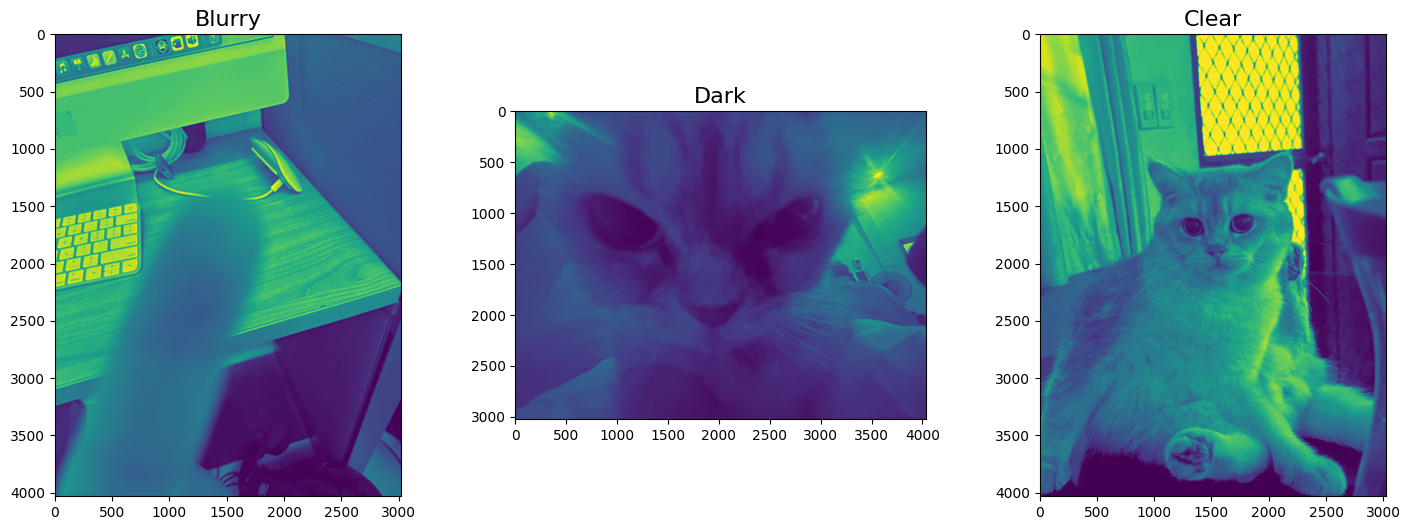

In [11]:
images = [img_blurry, img_dark, img_clear]
titles = ['Blurry', 'Dark', 'Clear']
plot_images(images, titles, 3, 16, True)

[39 39 39 ... 93 93 93]
[102 102 102 ...  32  32  32]
[236 237 237 ...   9   9   9]


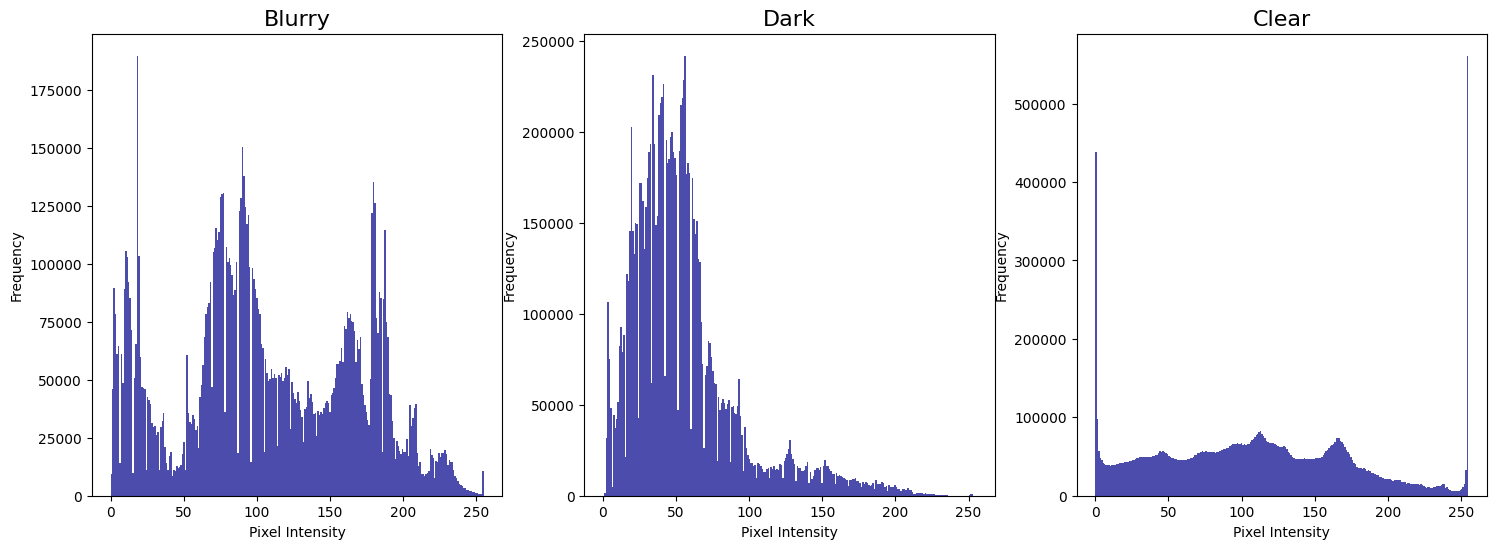

In [12]:
plot_hist(images, titles, 3, 16, 256, 'darkblue')

mean filter and evaluation

In [13]:
clear_mean_filter = mean_filter(img_clear, (3,3))
pprint.pp(evaluate(img_clear, clear_mean_filter))

{'RMSE: ': 0.015918171073652485,
 'MSE: ': 4.297815967629336,
 'PSNR: ': 41.7983254579304,
 'SSIM: ': 0.9764874276642208}


In [14]:
dark_mean_filter = mean_filter(img_dark, (3,3))
pprint.pp(evaluate(img_dark, dark_mean_filter))

{'RMSE: ': 0.013516277235209703,
 'MSE: ': 0.8280922756834215,
 'PSNR: ': 48.95001627238538,
 'SSIM: ': 0.9974600034615705}


In [15]:
blurry_mean_filter = mean_filter(img_blurry, (3,3))
pprint.pp(evaluate(img_blurry, blurry_mean_filter))

{'RMSE: ': 0.010905961924659906,
 'MSE: ': 1.8055179923049467,
 'PSNR: ': 45.56478540262461,
 'SSIM: ': 0.9974446713504113}


[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[236 237 237 ...  32  39  44]
 [237 237 237 ...  32  36  39]
 [240 240 239 ...  34  34  35]
 ...
 [ 35  34  33 ...   9   9   9]
 [ 33  30  27 ...   9   9   9]
 [ 25  20  13 ...   9   9   9]]
[[ 17  26  26 ...  77  77  51]
 [ 26  39  39 ... 115 115  77]
 [ 26  39  39 ... 115 115  77]
 ...
 [ 50  75  75 ...  93  93  62]
 [ 50  75  75 ...  93  93  62]
 [ 33  50  50 ...  62  62  41]]
[[ 45  68  68 ...  51  51  34]
 [ 68 102 102 ...  76  76  51]
 [ 68 102 102 ...  76  76  51]
 ...
 [ 39  59  59 ...  32  32  21]
 [ 39  59  59 ...  32  32  21]
 [ 26  39  39 ...  21  21  14]]
[[105 158 158 ...  22  25  18]
 [159 238

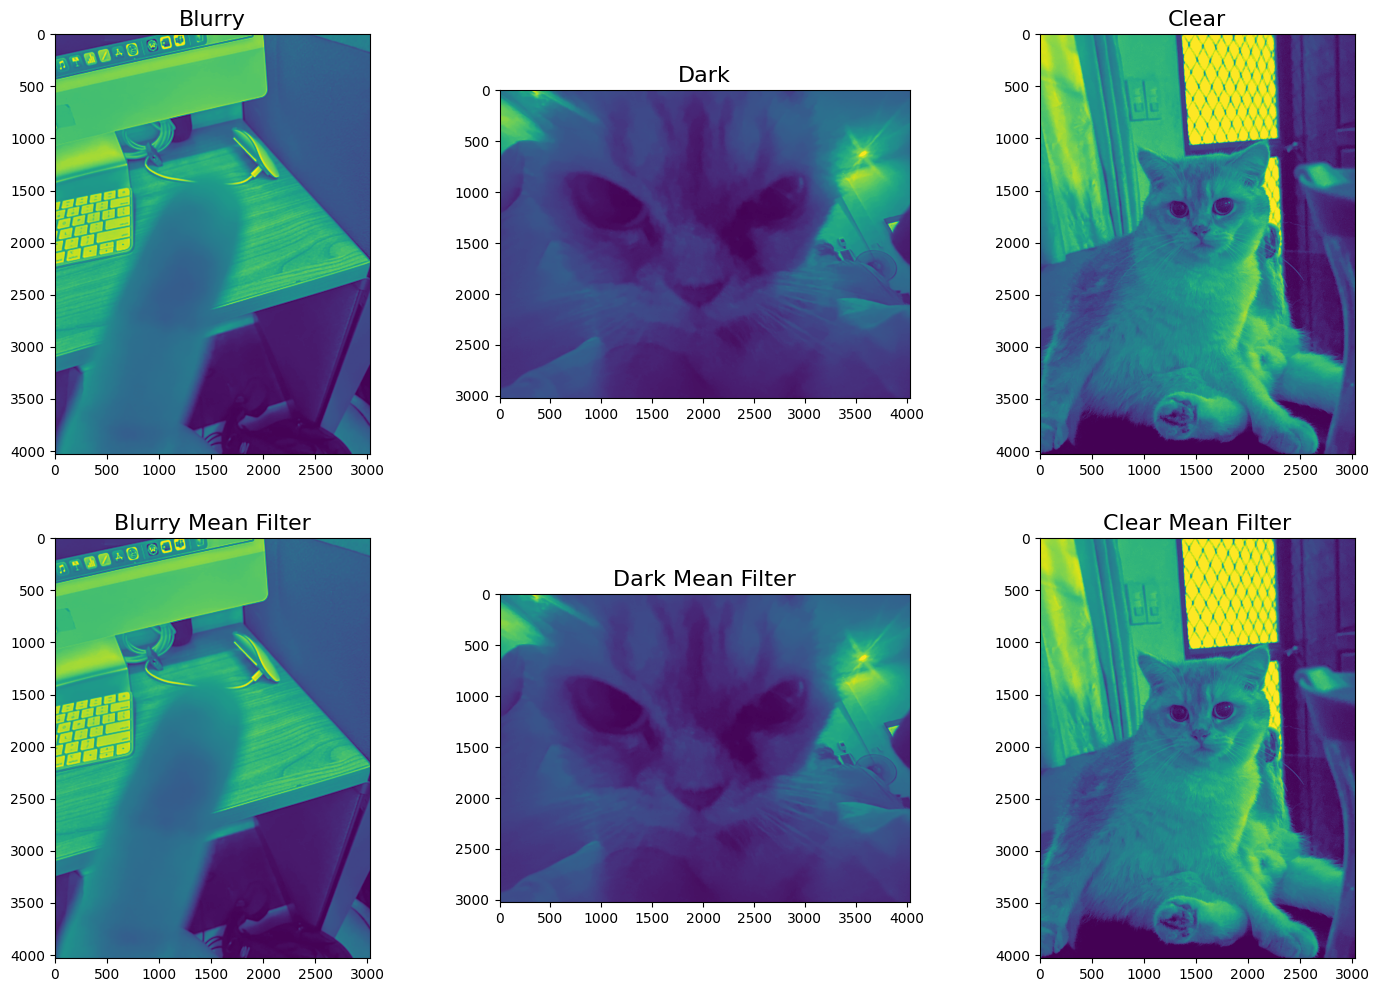

In [16]:
images = [img_blurry, img_dark, img_clear, blurry_mean_filter, dark_mean_filter, clear_mean_filter,]
titles = ['Blurry', 'Dark', 'Clear', 'Blurry Mean Filter','Dark Mean Filter', 'Clear Mean Filter']
plot_images(images, titles, 3, 16, True)

median filter and evaluation

In [17]:
blurry_median_filter = median_filter(img_blurry, 9, use_cv = True)
pprint.pp(evaluate(img_blurry, blurry_median_filter))

{'RMSE: ': 0.007559123518281036,
 'MSE: ': 0.8673946719891661,
 'PSNR: ': 48.748636107203865,
 'SSIM: ': 0.9945103434646141}


In [18]:
dark_median_filter = median_filter(img_dark, 9, use_cv = True)
pprint.pp(evaluate(img_dark, dark_median_filter))

{'RMSE: ': 0.009916160070889558,
 'MSE: ': 0.44570921057466195,
 'PSNR: ': 51.640287519995496,
 'SSIM: ': 0.9944684064521423}


In [19]:
clear_median_filter = median_filter(img_clear, 9, use_cv = True)
pprint.pp(evaluate(img_clear, clear_median_filter))

{'RMSE: ': 0.035457952677163944,
 'MSE: ': 21.32498781244751,
 'PSNR: ': 34.84191569234132,
 'SSIM: ': 0.8264218932310115}


[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[236 237 237 ...  32  39  44]
 [237 237 237 ...  32  36  39]
 [240 240 239 ...  34  34  35]
 ...
 [ 35  34  33 ...   9   9   9]
 [ 33  30  27 ...   9   9   9]
 [ 25  20  13 ...   9   9   9]]
[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[237 237 237 ...  35  39  39]
 [237 238

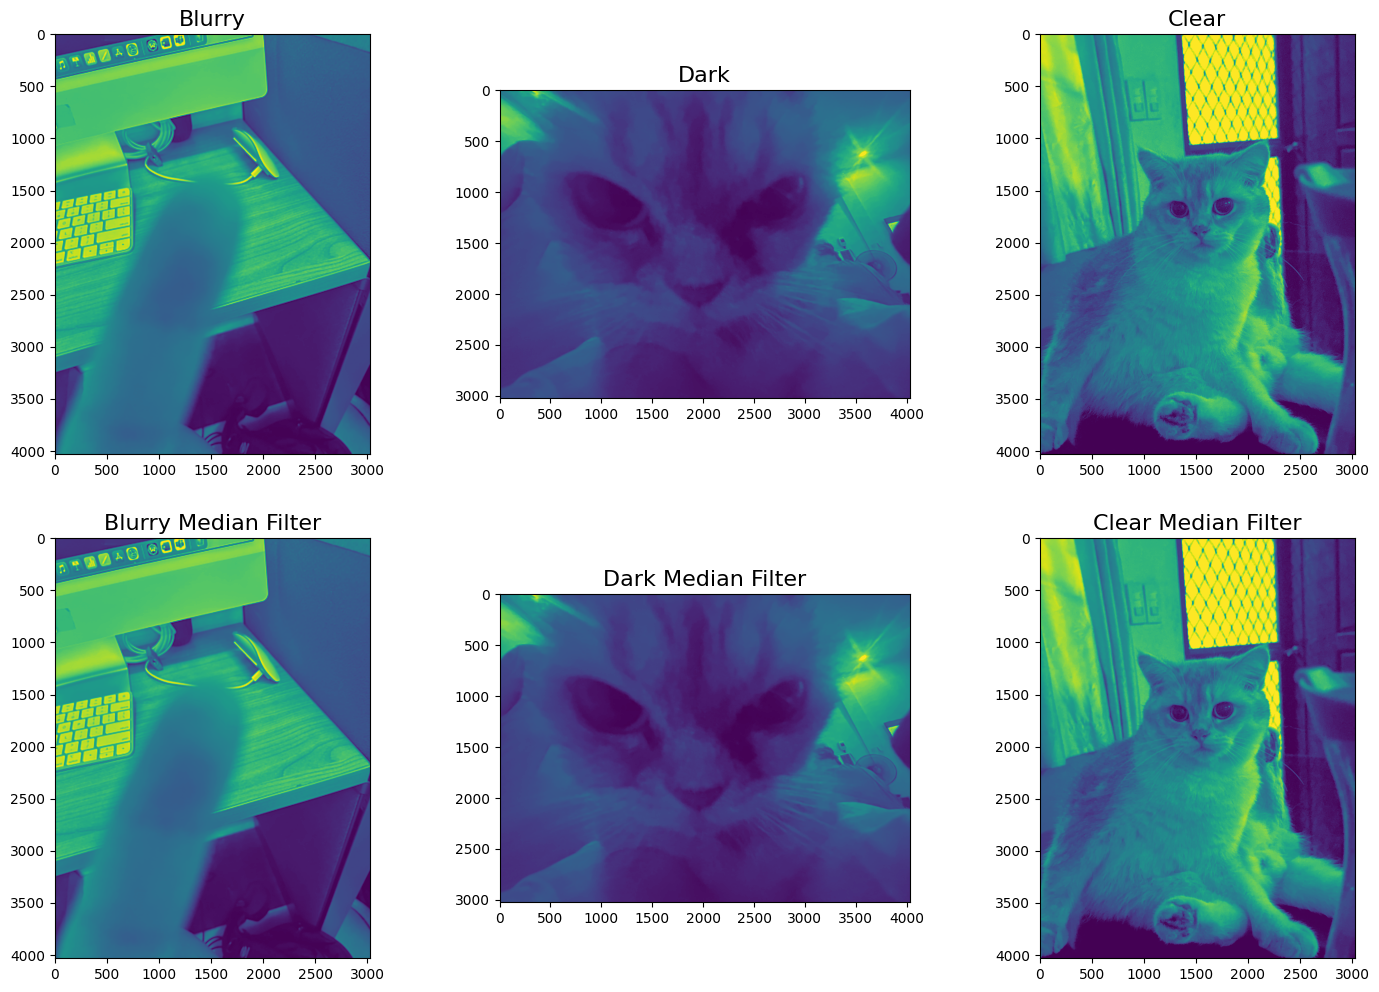

In [20]:
images = [img_blurry, img_dark, img_clear, blurry_median_filter, dark_median_filter, clear_median_filter]
titles = ['Blurry', 'Dark', 'Clear', 'Blurry Median Filter','Dark Median Filter', 'Clear Median Filter']
plot_images(images, titles, 3, 16, True)

adaptive median filter and evaluation

In [21]:
blurry_adaptive_median_filter = adaptive_median_filter(img_blurry, ws=3, ws_max=7, axis=(0, 1), mode='constant')
pprint.pp(evaluate(img_blurry, blurry_adaptive_median_filter))

{'RMSE: ': 0.0035628831334428086,
 'MSE: ': 0.19269791732279332,
 'PSNR: ': 55.282033400376065,
 'SSIM: ': 0.997730517727249}


In [22]:
dark_adaptive_median_filter = adaptive_median_filter(img_dark, ws=3, ws_max=7, axis=(0, 1), mode='constant')
pprint.pp(evaluate(img_dark, dark_adaptive_median_filter))

{'RMSE: ': 0.00674512317271606,
 'MSE: ': 0.20622642865016377,
 'PSNR: ': 54.98736039971638,
 'SSIM: ': 0.9971335818765824}


In [23]:
clear_adaptive_median_filter = adaptive_median_filter(img_clear, ws=3, ws_max=7, axis=(0, 1), mode='constant')
pprint.pp(evaluate(img_clear, clear_adaptive_median_filter))

{'RMSE: ': 0.011858405926069784,
 'MSE: ': 2.385141257506089,
 'PSNR: ': 44.355662560918745,
 'SSIM: ': 0.9800128105332951}


[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[236 237 237 ...  32  39  44]
 [237 237 237 ...  32  36  39]
 [240 240 239 ...  34  34  35]
 ...
 [ 35  34  33 ...   9   9   9]
 [ 33  30  27 ...   9   9   9]
 [ 25  20  13 ...   9   9   9]]
[[  0   0   0 ...   0   0   0]
 [  0   0  39 ... 115   0   0]
 [  0  39  39 ... 115 115   0]
 ...
 [  0  75  75 ...  93  93   0]
 [  0  75  75 ...  93   0   0]
 [  0   0  75 ...   0   0   0]]
[[  0   0   0 ...   0   0   0]
 [  0   0 102 ...  76   0   0]
 [  0 102 102 ...  76  76   0]
 ...
 [  0  59  59 ...  32  32   0]
 [  0   0  59 ...  32   0   0]
 [  0   0   0 ...   0   0   0]]
[[  0   0 237 ...  31  32   0]
 [237 237

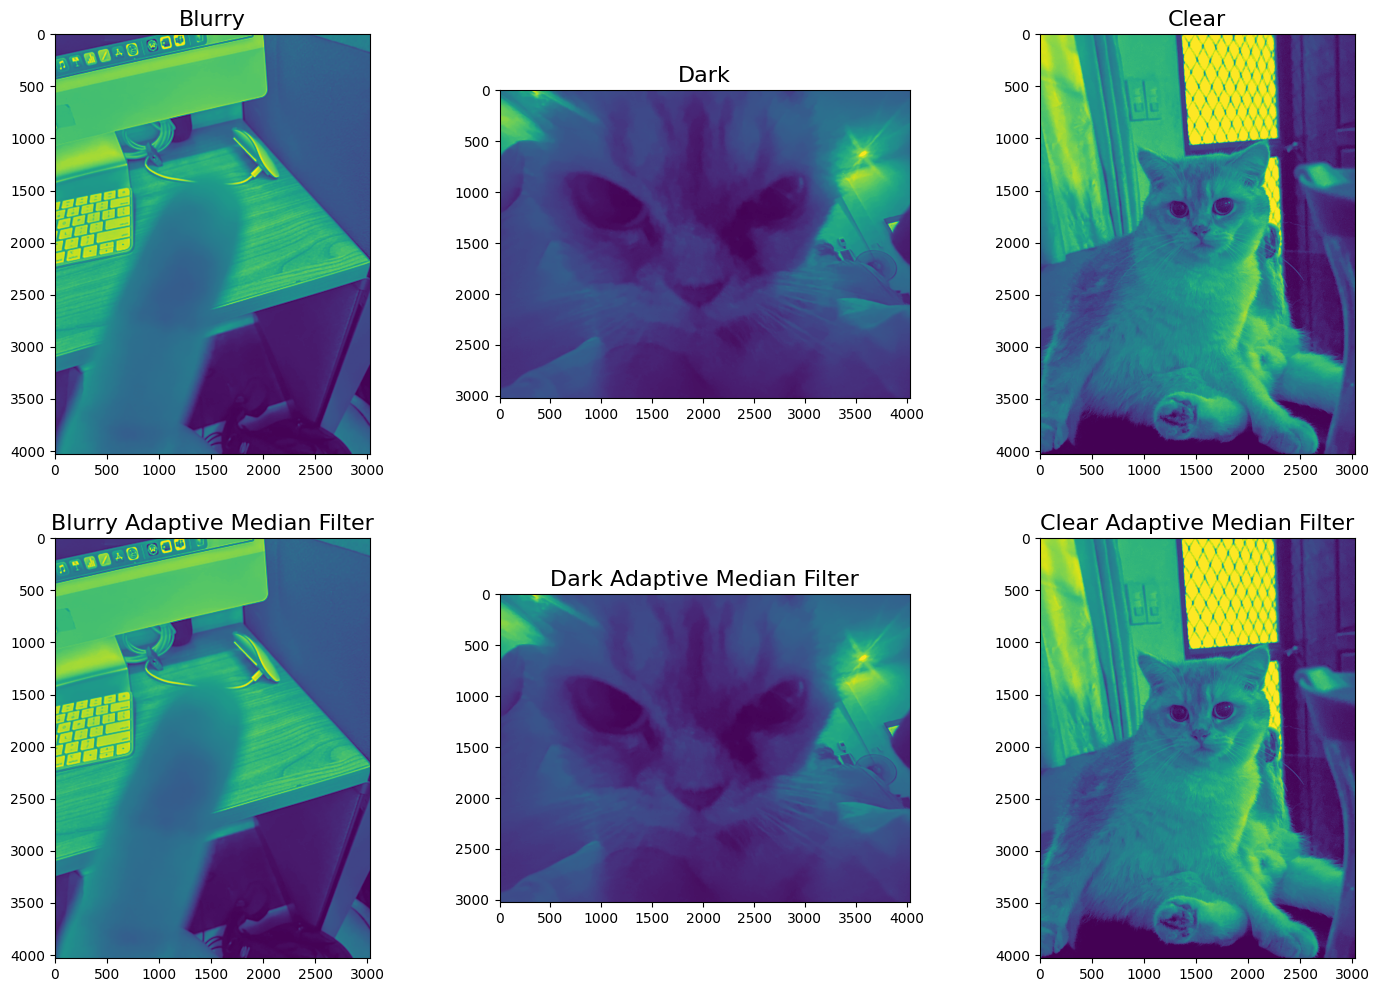

In [24]:
images = [img_blurry, img_dark, img_clear, blurry_adaptive_median_filter, dark_adaptive_median_filter, clear_adaptive_median_filter]
titles = ['Blurry', 'Dark', 'Clear', 'Blurry Adaptive Median Filter','Dark Adaptive Median Filter', 'Clear Adaptive Median Filter']
plot_images(images, titles, 3, 16, True)

alpha trimmed median filter and evaluation

In [ ]:
blurry_atmf = alpha_trimmed_mean_filter(img_blurry)
pprint.pp(evaluate(img_blurry, blurry_atmf))

In [ ]:
dark_atmf = alpha_trimmed_mean_filter(img_dark)
pprint.pp(evaluate(img_dark, dark_atmf))

{'RMSE: ': 0.007454227773662265,
 'MSE: ': 0.25186618821911483,
 'PSNR: ': 54.11910491327171,
 'SSIM: ': 0.9970418936491666}


In [ ]:
clear_atmf = alpha_trimmed_mean_filter(img_clear)
pprint.pp(evaluate(img_clear, clear_atmf))

{'RMSE: ': 0.012473492190322334,
 'MSE: ': 2.6389891122344,
 'PSNR: ': 43.91642762427427,
 'SSIM: ': 0.9789744702660215}


[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[236 237 237 ...  32  39  44]
 [237 237 237 ...  32  36  39]
 [240 240 239 ...  34  34  35]
 ...
 [ 35  34  33 ...   9   9   9]
 [ 33  30  27 ...   9   9   9]
 [ 25  20  13 ...   9   9   9]]
[[ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 [ 39  39  39 ... 115 115 115]
 ...
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]
 [ 75  75  75 ...  93  93  93]]
[[102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 [102 102 102 ...  76  76  76]
 ...
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]
 [ 59  59  59 ...  32  32  32]]
[[237 237 237 ...  32  36  37]
 [237 237

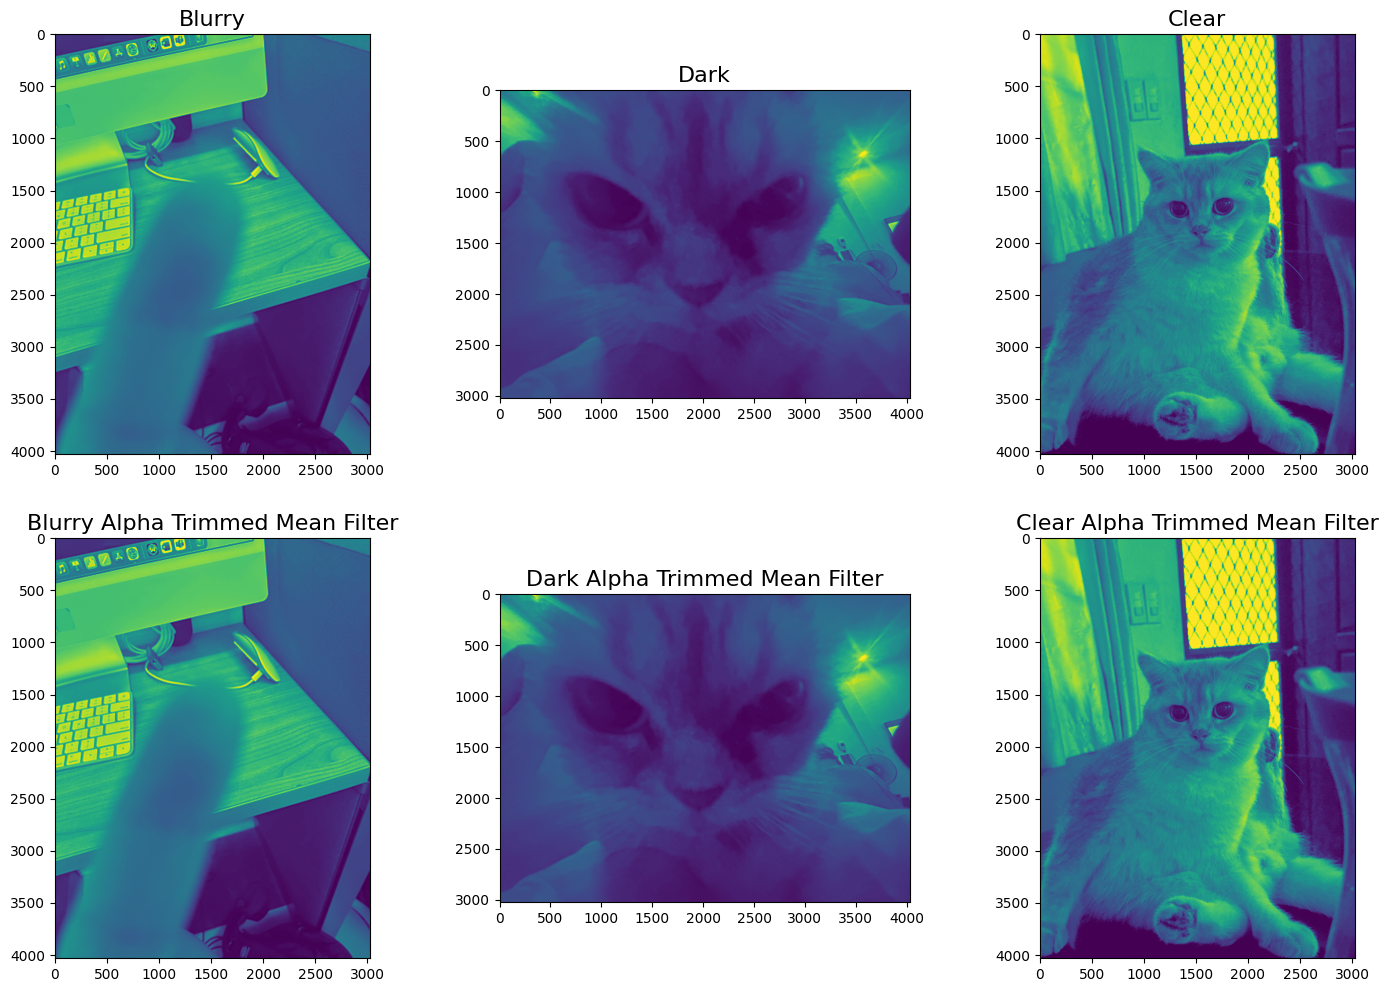

In [ ]:
images = [img_blurry, img_dark, img_clear, blurry_atmf, dark_atmf, clear_atmf]
titles = ['Blurry', 'Dark', 'Clear', 'Blurry Alpha Trimmed Mean Filter','Dark Alpha Trimmed Mean Filter', 'Clear Alpha Trimmed Mean Filter']
plot_images(images, titles, 3, 16, True)